In [2]:
import urllib
import os
import sqlite3
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


In [3]:
FILES_URL = 'https://datasette.planning.data.gov.uk/'

def download_dataset(dataset, output_dir_path, overwrite=False):
    dataset_file_name = f'{dataset}.db'
    
    if not os.path.exists(output_dir_path):
        os.makedirs(output_dir_path)
    
    output_file_path = os.path.join(output_dir_path, dataset_file_name)

    if overwrite is False and os.path.exists(output_file_path):
        return
    
    final_url = os.path.join(FILES_URL, dataset_file_name)
    print(f'downloading data from {final_url}')
    print(f'to: {output_file_path}')
    urllib.request.urlretrieve(final_url, os.path.join(output_dir_path, dataset_file_name))
    print('download complete')

In [4]:
def query_sqlite(db_path, query_string):

    with sqlite3.connect(db_path) as con:
            
        cursor = con.execute(query_string)
        cols = [column[0] for column in cursor.description]
        results_df = pd.DataFrame.from_records(data=cursor.fetchall(), columns=cols)

    return results_df

In [5]:

def datasette_query(db, sql_string):
    params = urllib.parse.urlencode({
        "sql": sql_string,
        "_size": "max"
        })
    url = f"https://datasette.planning.data.gov.uk/{db}.csv?{params}"
    df = pd.read_csv(url)
    return df

def get_issue_lookup():
    
    q = """
    select issue_type, severity, responsibility
    from issue_type
"""
    return datasette_query("digital-land", q)

In [6]:
data_dir = "../../data/db_downloads/"
os.makedirs(data_dir, exist_ok=True)

## Get data

In [7]:
download_dataset("performance", data_dir, overwrite=True)
# download_dataset("article-4-direction-area", data_dir, overwrite=True)
# download_dataset("tree-preservation-zone", data_dir, overwrite=True)

downloading data from https://datasette.planning.data.gov.uk/performance.db
to: ../../data/db_downloads/performance.db
download complete


In [122]:
lookup_issue_qual = pd.read_csv("data/issue_type_quality.csv")

## Analysis

In [19]:
subset_odp = ["conservation-area", "conservation-area-document", "article-4-direction-area", "article-4-direction", "listed-building-outline", "tree", "tree-preservation-zone", "tree-preservation-order"]
subset_bfl = ["brownfield-land"]
subset_dvl = ["developer-agreement", "developer-agreement-contribution", "developer-agreement-transaction"]

In [39]:
# BASE TABLE

# get table of active endpoints and resources, with issue summaries per resource joined on
q = f"""
    SELECT 
        rhe.organisation, rhe.name as organisation_name, rhe.collection, rhe.pipeline, rhe.endpoint, rhe.resource, rhe.latest_status, rhe.endpoint_entry_date, rhe.resource_start_date, 
        CAST(JULIANDAY('now') - JULIANDAY(rhe.resource_start_date) AS int) as resource_age_days,
        its.issue_type, its.count_issues, its.severity, its.responsibility
    FROM reporting_historic_endpoints rhe
    LEFT JOIN endpoint_dataset_issue_type_summary its on rhe.resource = its.resource
    WHERE 1=1
        AND rhe.endpoint_end_date = ""
        AND rhe.resource_end_date = ""
        AND rhe.latest_status = 200
"""

ep_res_issues = query_sqlite(os.path.join(data_dir, "performance.db"), q)

print(len(ep_res_issues))
ep_res_issues.head()

2837


,organisation,organisation_name,collection,pipeline,endpoint,resource,latest_status,endpoint_entry_date,resource_start_date,resource_age_days,issue_type,count_issues,severity,responsibility
0,development-corporation:Q20648596,Old Oak and Park Royal Development Corporation,brownfield-land,brownfield-land,a16e45dbefe2d67a6d27c086768b6c3610d4e057bb1962...,f1e218c96f99e378fdbaed9a426c6b44d0e7d3b5fec63e...,200,2019-12-01,2019-12-01,1786,patch,1.0,info,internal
1,development-corporation:Q20648596,Old Oak and Park Royal Development Corporation,brownfield-land,brownfield-land,a16e45dbefe2d67a6d27c086768b6c3610d4e057bb1962...,f1e218c96f99e378fdbaed9a426c6b44d0e7d3b5fec63e...,200,2019-12-01,2019-12-01,1786,default-field,41.0,info,internal
2,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",area-of-outstanding-natural-beauty,area-of-outstanding-natural-beauty,34167c688ca765477c47e63592ff9149bb46710a0850f6...,d4f9a4c7d1bda9026c2079812c5f2fc9e6de231b111b7e...,200,2022-09-10,2024-10-03,18,None,NaN,None,None
3,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",article-4-direction,article-4-direction-rule,e5598a75328d5890efb7e6d8bb6c1d181fbed2cda45af2...,44938e5a202309da506987cb84eb51fe789993f0870a9a...,200,2022-10-11,2022-10-25,727,None,NaN,None,None
4,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",conservation-area,conservation-area,ab8e712f15d91a4a95c2e89eacdbe324c8783eaa6f0b3b...,b1e308f77bd15328b39331ea23da6c21f5b8a945b39d97...,200,2024-09-24,2024-09-25,26,None,NaN,None,None


### Provision view

In [32]:
prov_summary_now = ep_res_issues[["organisation", "name", "collection", "pipeline"]].drop_duplicates().groupby(
    ["collection", "pipeline"], as_index=False
    ).agg(
    n_providers = ("organisation", "size")
)

prov_summary_now.head(10)

,collection,pipeline,n_providers
0,agricultural-land-classification,agricultural-land-classification,1
1,ancient-woodland,ancient-woodland,1
2,ancient-woodland,ancient-woodland-status,1
3,area-of-outstanding-natural-beauty,area-of-outstanding-natural-beauty,2
4,article-4-direction,article-4-direction,15
5,article-4-direction,article-4-direction-area,29
6,article-4-direction,article-4-direction-rule,1
7,border,border,1
8,brownfield-land,brownfield-land,274
9,brownfield-site,brownfield-site,3


In [21]:
# get table of active endpoints and resources, with issue summaries per resource joined on
q = f"""
    SELECT 
        organisation, organisation_name, dataset, active_endpoint_count,
        CASE WHEN active_endpoint_count > 0 then 1 else 0 end as active_endpoint_flag
    FROM provision_summary 
"""

prov_all = query_sqlite(os.path.join(data_dir, "performance.db"), q)
prov_all

,organisation,organisation_name,dataset,active_endpoint_count,active_endpoint_flag
0,development-corporation:Q105544651,Aycliffe and Peterlee Development Corporation,brownfield-site,0,0
1,development-corporation:Q105544651,Aycliffe and Peterlee Development Corporation,developer-agreement,0,0
2,development-corporation:Q105544651,Aycliffe and Peterlee Development Corporation,developer-agreement-contribution,0,0
3,development-corporation:Q105544651,Aycliffe and Peterlee Development Corporation,developer-agreement-transaction,0,0
4,development-corporation:Q105544654,Basildon Development Corporation,brownfield-site,0,0
...,...,...,...,...,...
5719,national-park-authority:Q72617988,Peak District National Park Authority,development-plan-timetable,0,0
5720,national-park-authority:Q72617988,Peak District National Park Authority,listed-building-outline,0,0
5721,national-park-authority:Q72617988,Peak District National Park Authority,tree,0,0
5722,national-park-authority:Q72617988,Peak District National Park Authority,tree-preservation-order,0,0


#### Current

In [43]:
prov_summary_now = prov_all.groupby(
    ["dataset"], as_index=False
    ).agg(
    n_providers = ("active_endpoint_flag", "sum"),
    n_expected = ("active_endpoint_flag", "size")
)

prov_summary_now["trusted_data"] = prov_summary_now["n_providers"]
prov_summary_now["no_data"] = prov_summary_now["n_expected"] - prov_summary_now["n_providers"]

prov_summary_now.head()

,dataset,n_providers,n_expected,trusted_data,no_data
0,agricultural-land-classification,1,1,1,0
1,ancient-woodland,1,1,1,0
2,area-of-outstanding-natural-beauty,1,1,1,0
3,article-4-direction,16,324,16,308
4,article-4-direction-area,30,324,30,294


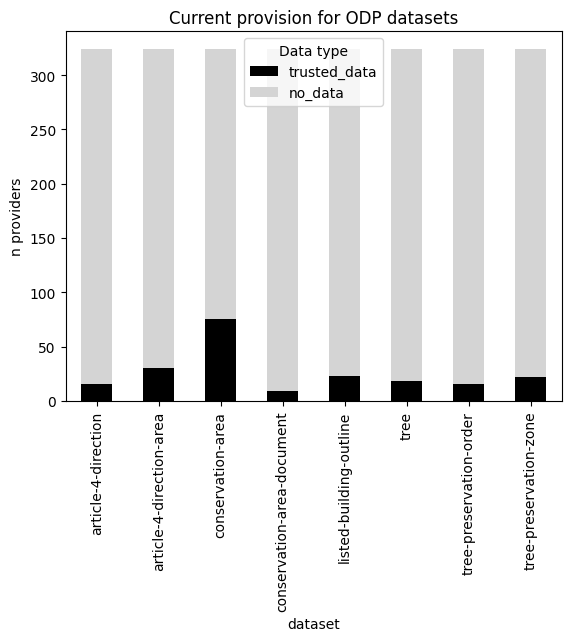

In [96]:
prov_summary_chart = prov_summary_now[prov_summary_now["dataset"].isin(subset_odp)]

prov_summary_chart[["dataset", "trusted_data", "no_data"]].plot.bar(x = "dataset", stacked = True, color = ["black", "#d4d4d4"])

plt.ylabel('n providers')
plt.title(f'Current provision for ODP datasets')
plt.legend(title='Data type')
plt.show()

#### Historic

In [75]:
def get_active_endpoints(dataset, date):

    q = f"""
        select distinct pipeline as dataset, name, DATE('{date}') as active_date, endpoint_entry_date, endpoint_end_date
        from reporting_historic_endpoints 
        where
            pipeline = '{dataset}'
            and endpoint_entry_date <= DATE('{date}')
            and (
                endpoint_end_date > DATE('{date}')
                or endpoint_end_date = "")
"""
    
    df = query_sqlite(os.path.join(data_dir, "performance.db"), q)

    return df

# test = get_active_endpoints("tree-preservation-zone", "2024-07-11")
# test

23
23


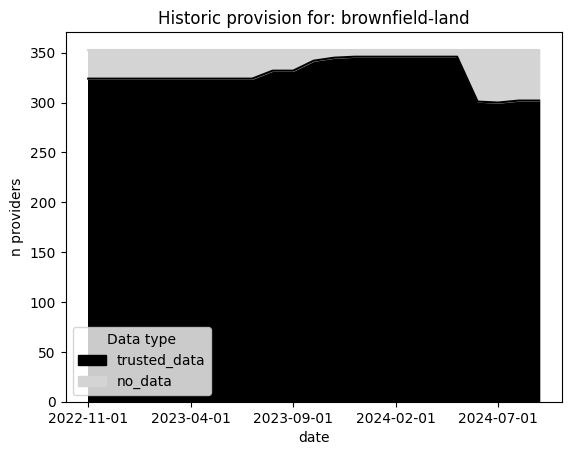

In [98]:
dataset = "brownfield-land"

date_range = pd.date_range(end = "20241001", periods = 24, freq = "MS").format("%Y-%m-%d")

prov_hist = [get_active_endpoints(dataset, d) for d in date_range[1:-1]]
prov_hist_df = pd.concat(prov_hist)

prov_summary_hist = prov_hist_df[["dataset", "name", "active_date"]].drop_duplicates().groupby(["active_date", "dataset"], as_index = False).agg(
    n_providers = ("dataset", "size")
)

print(len(prov_summary_hist))
prov_summary_hist = prov_summary_hist.merge(
    prov_summary_now[["dataset", "n_expected"]],
    how = "left",
    on = "dataset"
)

prov_summary_hist["trusted_data"] = prov_summary_hist["n_providers"]
prov_summary_hist["no_data"] = prov_summary_hist["n_expected"] - prov_summary_hist["n_providers"]

print(len(prov_summary_hist))
# prov_summary_hist
prov_summary_hist[["dataset", "active_date", "trusted_data", "no_data"]].plot.area(x = "active_date", stacked = True, color = ["black", "#d4d4d4"])

plt.xlabel('date')
plt.ylabel('n providers')
plt.title(f'Historic provision for: {dataset}')
plt.legend(title='Data type')
plt.show()

### Data quality view

In [124]:
# FRESHNESS TABLE

# create table of old resources and flag quality level as 5
ep_res_fresh_qual = ep_res_issues[ep_res_issues["resource_age_days"] > 365][["collection", "pipeline", "organisation", "organisation_name"]]

ep_res_fresh_qual["issue_type"] = "not_fresh"
ep_res_fresh_qual["quality_level"] = 4

In [106]:
# ep_res_issues

In [190]:
# ISSUES TABLE

# join on quality key and restrict fields
ep_res_issues_qual = ep_res_issues.merge(
    lookup_issue_qual[["issue_type", "quality_key", "quality_level"]],
    how = "left",
    on = "issue_type"
)[["collection", "pipeline", "organisation", "organisation_name", "issue_type", "quality_level"]]

# ep_res_issues_qual = ep_res_issues_qual[ep_res_issues_qual["issue_type"].notnull()]

print(len(ep_res_issues))
print(len(ep_res_issues_qual))

# ep_res_issues_qual.head()

2837
2837


In [191]:
# ALL QUALITY CATEGORIES TABLE
# concat tables for each type
ep_res_qual_all = pd.concat([ep_res_issues_qual, ep_res_fresh_qual])


In [192]:
# SCORING
# summarise by provision, taking max quality level for each
qual_summary = ep_res_qual_all.groupby([
    "collection", "pipeline", "organisation", "organisation_name"
    ],
as_index=False
).agg(
    quality_level = ("quality_level", "max")
)

qual_summary.replace(np.nan, 1, inplace=True)

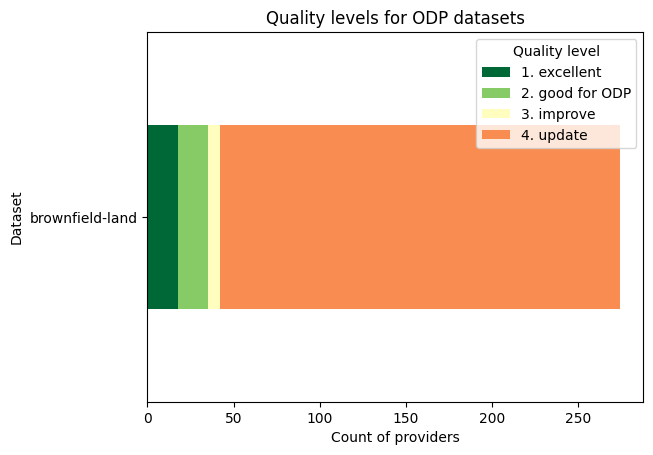

In [197]:
# VISUALISE

# qual_summary_subset = qual_summary[qual_summary["pipeline"].isin(subset_odp)]
qual_summary_subset = qual_summary[qual_summary["pipeline"].isin(subset_bfl)]
# qual_summary_subset = qual_summary[qual_summary["pipeline"].isin(subset_dvl)]


cmap = plt.get_cmap('RdYlGn_r')
colors = [cmap(i / 4) for i in range(4)]

level_map = {
    1: "1. excellent",
    2: "2. good for ODP",
    3: "3. improve",
    4: "4. update"}

qual_chart = qual_summary_subset.groupby(["pipeline", "quality_level"], as_index=False).agg(
    n_providers = ("quality_level", "count")
)

qual_chart["quality_level_label"] = qual_chart["quality_level"].map(level_map)
qual_chart.sort_values(["pipeline", "quality_level_label"], inplace=True)
qual_chart.pivot(columns = "quality_level_label", values = "n_providers", index = "pipeline").plot.barh(stacked = True, color = colors)

# Add labels and title
plt.xlabel('Count of providers')
plt.ylabel('Dataset')
plt.title('Quality levels for ODP datasets')
plt.legend(title='Quality level')

plt.show()

In [194]:
qual_summary_subset[qual_summary_subset["pipeline"] == "tree"]

,collection,pipeline,organisation,organisation_name,quality_level
641,tree-preservation-order,tree,local-authority-eng:BNE,London Borough of Barnet,1.0
642,tree-preservation-order,tree,local-authority-eng:BST,Bristol City Council,3.0
643,tree-preservation-order,tree,local-authority-eng:BUC,Buckinghamshire Council,1.0
644,tree-preservation-order,tree,local-authority-eng:DNC,Doncaster Metropolitan Borough Council,1.0
645,tree-preservation-order,tree,local-authority-eng:DOV,Dover District Council,1.0
646,tree-preservation-order,tree,local-authority-eng:GAT,Gateshead Metropolitan Borough Council,1.0
647,tree-preservation-order,tree,local-authority-eng:GLO,Gloucester City Council,1.0
648,tree-preservation-order,tree,local-authority-eng:LBH,London Borough of Lambeth,3.0
649,tree-preservation-order,tree,local-authority-eng:NET,Newcastle City Council,4.0
650,tree-preservation-order,tree,local-authority-eng:NLN,North Lincolnshire Council,1.0


In [195]:
qual_chart.groupby(["quality_level", "quality_level_label"], as_index = False).agg(
    total = ("n_providers", "sum")
)

,quality_level,quality_level_label,total
0,1.0,1. excellent,100
1,2.0,2. good for ODP,25
2,3.0,3. improve,29
3,4.0,4. update,30


In [196]:
# Check some specifics - conservation area "update"

dataset = "conservation-area"
level = 4

level_provisions = ep_res_qual_all[
    (ep_res_qual_all["pipeline"] == dataset) & 
    (ep_res_qual_all["quality_level"] == level)][
        ["pipeline", "organisation"]
    ].drop_duplicates()

level_prov_all_issues = level_provisions.merge(
    ep_res_qual_all,
    how = "left", 
    on = ["pipeline", "organisation"]
    )

level_prov_all_issues[level_prov_all_issues["quality_level"].notnull()].drop_duplicates().groupby(["issue_type"], as_index=False).size()

,issue_type,size
0,not_fresh,21
1,reference values are not unique,3
2,unknown entity,1
3,unknown entity - missing reference,4


In [180]:
# Check some specifics - conservation area "update"

dataset = "tree-preservation-zone"
level = 3

level_provisions = qual_summary[
    (qual_summary["pipeline"] == dataset) & 
    (qual_summary["quality_level"] == level)][
        ["pipeline", "organisation"]
    ].drop_duplicates()

level_prov_all_issues = level_provisions.merge(
    ep_res_qual_all,
    how = "left", 
    on = ["pipeline", "organisation"]
    )

level_prov_all_issues[level_prov_all_issues["quality_level"].notnull()].drop_duplicates().groupby(["issue_type"], as_index=False).size()

,issue_type,size
0,invalid category value,2
1,invalid date,2
2,missing value,2
3,reference values are not unique,5
4,unknown entity,1
5,unknown entity - missing reference,2
